<center>

# Visualization and Storytelling  
# Assignment 2 – Redesign a Notable Information Graphic  

## Hazal Turken 
## 101034120  

</center>


# Introduction

In this notebook, we will explore one of the most iconic examples of data-driven storytelling in public health: the cholera outbreak in London during the mid-19th century.

Our goal is to reconstruct the logic behind John Snow’s investigation and to understand how spatial data visualization helped uncover the source of the epidemic.

Through a combination of maps, charts, and interactive elements, we will move from raw geographic data to meaningful insights, showing how visualization can transform data into evidence.



# John Snow’s Cholera Map

Dr. John Snow (1813–1858) is often considered the pioneer of modern epidemiology.  

During the 1854 cholera outbreak in London, Snow challenged the dominant miasma theory which claimed that diseases spread through “bad air.” Instead, he hypothesized that cholera was transmitted through contaminated water and used a hand-drawn map to support his argument.  


<img src="images/JohnSnow.png" width="500">


By plotting the locations of deaths and water pumps in the Soho district, he revealed a clear spatial pattern: most cases clustered around a single pump on Broad Street. This discovery not only revolutionized public health but also became one of the earliest examples of using data visualization as a scientific method.  

Today, Snow’s map is seen as a cornerstone in both epidemiology and geospatial analytics; bridging medicine, data science, and storytelling.  

<img src="images/CholeraMap.png" width="800">


# Audience

This visualization is designed for audiences interested in public health, data visualization, and the history of epidemiology. It targets students, researchers, and data enthusiasts who want to explore how spatial and temporal data can reveal patterns of disease transmission. By combining historical context with modern interactivity, it engages both academic viewers seeking analytical insight and general audiences curious about how data storytelling can transform historical evidence.

# Iteration 1 - Planning & Exploration

At the beginning of the project, my main goal was to recreate John Snow’s 1854 cholera outbreak map in a modern, interactive format.
I explored different ways to visualize the spatial relationship between death locations and water pumps. Initially, I tried 3D map environments and platforms like 3d mapper and Kepler.gl as seen in the picture below.

However, these approaches were either too complex or visually overwhelming for such a small area like Soho, London.


![image.png](images/3dMap.png)


I also experimented with adding timeline animations as seen in the picture below to represent deaths over time, but the data didn’t include precise temporal information. So, I decided to focus purely on the spatial analysis instead.

![image.png](images/TimelineMap.png)

At that point, my plan was to build the visualization in Python (Folium + Plotly), combining interactive maps with small analytical charts.
I wasn’t yet sure what type of chart would make sense. At first, I considered pie charts or density rings, but eventually, I leaned toward a bar chart showing deaths by distance from each pump and a timeline line graph o show how daily deaths changed around September.

# Iteration 2 — Visual Refinement

In the second stage, I worked on improving the map’s design and readability.
My earlier versions were more colorful and detailed as seen in the picture down below, but that made it harder to focus on the key message.
I switched to a minimal, grayscale base map which helped the data stand out clearly.

![image.png](images/Map1.png)

The pump markers were originally bright red, but visually, it resembled blood drops, which didn’t feel appropriate for this topic.
So, I changed them to dark blue, which fits the clean, analytical style better.

![image.png](images/Map2.png)

Initially, deaths were shown as black dots, one per death location.
While this was historically accurate, it made the map visually noisy.
To simplify the visualization, I replaced the dots with a heatmap, representing density more smoothly.

# Iteration 3 — Final Version

The final version combines all the elements into a clean, interactive visualization.
Each pump is clickable — when selected, it opens a mini bar chart showing the number of deaths by distance ring (0–25m, 25–50m, 50–75m, 75–100m).
This makes it possible to quickly see how deaths clustered more heavily around the Broad Street pump, confirming John Snow’s original discovery.

![image.png](images/BarGraph.png)

The heatmap now visually complements the charts, it provides an overall density overview, while the bar graphs give local quantitative insights.
The result is a balance between historical accuracy and modern interactivity, showing how a 19th-century epidemiological map can be reinterpreted through data visualization tools like Folium, GeoPandas, and Plotly.

# Mapping Cholera Deaths Near Water Pumps

We start by importing all the necessary Python libraries for data manipulation, mapping, and visualization, including Folium for map creation and GeoPandas for handling shapefiles.

In [1]:
# Import libraries

import os, base64
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import HeatMap
import plotly.express as px

Here we define the file paths for the dataset. The deaths.csv and pumps.csv shapefiles are loaded to be used in our analysis.

In [2]:
# Open data paths

DEATHS_CSV = os.path.join(r"datas/deaths.csv") 
PUMPS_CSV  = os.path.join(r"datas/pumps.csv")

We define a helper function `_infer_lat_lon()` that automatically detects which columns in a given CSV contain latitude and longitude information. This ensures flexibility in case the dataset uses slightly different column names.

In [3]:
# Read csv

def _infer_lat_lon(df):
    cols = {c.lower(): c for c in df.columns}
  
    # Detect possible column names for latitude and longitude
    lat_key = next((k for k in ["lat", "latitude", "y"] if k in cols), None)
    lon_key = next((k for k in ["lon", "longitude", "x", "long"] if k in cols), None)
    
    if lat_key is None or lon_key is None:
        raise ValueError("Latitude/Longitude columns could not be found "
                         "Check CSV column names")
    return cols[lat_key], cols[lon_key]

Here, we load the `deaths.csv` file into a pandas DataFrame and extract the correct latitude and longitude columns using our helper function. We also check if there is a death_count or similar numeric column that can serve as a weighting factor for each point on the heatmap.

In [4]:
# Deaths

df_deaths = pd.read_csv(DEATHS_CSV)
lat_d, lon_d = _infer_lat_lon(df_deaths)
weight_col = next((c for c in df_deaths.columns if c.lower() in ["death_count","count","weight"]), None)


Next, we load the `pumps.csv` file, which contains the locations of water pumps that were investigated by John Snow. Just like with the deaths data, we automatically detect the latitude and longitude columns to prepare for spatial mapping.

In [5]:
# Pumps

df_pumps = pd.read_csv(PUMPS_CSV)
lat_p, lon_p = _infer_lat_lon(df_pumps)

We convert both datasets into GeoDataFrames with geographic coordinates and also project them into meters for distance-based spatial analysis.

In [6]:
# To GeoDataFrames

deaths_wgs = gpd.GeoDataFrame(
    df_deaths.copy(),
    geometry=gpd.points_from_xy(df_deaths[lon_d], df_deaths[lat_d]),
    crs="EPSG:4326"
)

pumps_wgs = gpd.GeoDataFrame(
    df_pumps.copy(),
    geometry=gpd.points_from_xy(df_pumps[lon_p], df_pumps[lat_p]),
    crs="EPSG:4326"
)

# Convert to British National Grid for meter-based spatial analysis
deaths_m = deaths_wgs.to_crs(27700)
pumps_m  = pumps_wgs.to_crs(27700)

We create a Folium base map centered on Soho, London, and add a heatmap layer showing the density of cholera deaths.

In [7]:
# Base Map + Heatmap

m = folium.Map([51.5134, -0.1366], zoom_start=17, tiles="CartoDB Positron")

# HeatMap data: [lat, lon, weight]
if weight_col is not None:
    heat_data = [[g.y, g.x, float(w)] for g, w in zip(deaths_wgs.geometry, deaths_wgs[weight_col]) if g is not None]
else:
    heat_data = [[g.y, g.x, 1.0] for g in deaths_wgs.geometry if g is not None]

HeatMap(
    heat_data,
    radius=18,
    blur=12,
    min_opacity=0.35,
    max_zoom=18,
    gradient={0.15:'blue', 0.35:'lime', 0.55:'yellow', 0.75:'red', 1.0:'darkred'}
).add_to(folium.FeatureGroup(name="Deaths — Heatmap", show=True).add_to(m))


We define a function that counts how many deaths occurred within specific distance rings (e.g., 0–25m, 25–50m) around each pump location.

In [8]:
# Ring Counts

def ring_counts(p_point_m, rings=(25, 50, 75, 100)):

    out, prev = [], 0
    for r in rings:
        ann = p_point_m.buffer(r).difference(p_point_m.buffer(prev))
        if weight_col is not None:
            # weighted count
            mask = deaths_m.within(ann)
            out.append(float(deaths_m.loc[mask, weight_col].sum()))
        else:
            out.append(int(deaths_m.within(ann).sum()))
        prev = r
    return out

We create interactive markers for each pump, showing a popup bar chart that visualizes how deaths are distributed by distance from that pump.

In [9]:
# Pumps + Popup Charts

pl = folium.FeatureGroup(name="Pumps", show=True)
labels = ["0–25m", "25–50m", "50–75m", "75–100m"]

# Combine three sources using zip: WGS84 geometry, meter-based geometry, row
for gw, gm, row in zip(pumps_wgs.geometry, pumps_m.geometry, pumps_wgs.itertuples()):
    counts = ring_counts(gm)
    total50 = counts[0] + counts[1]

    # Creating a bar chart showing deaths by distance rings
    fig = px.bar(pd.DataFrame({"Ring": labels, "Deaths": counts}),
                 x="Ring", y="Deaths",
                 title="Deaths by distance ring",
                 labels={"Ring": "Distance", "Deaths": "Count"})
    fig.update_layout(height=260, width=360,
                      margin=dict(l=30, r=20, t=40, b=30),
                      font=dict(size=10))

    # Convert to PNG 
    png = fig.to_image(format="png", width=360, height=260, scale=2)
    b64 = base64.b64encode(png).decode()

    pump_name = (
        getattr(row, "pump_name", None)
        or getattr(row, "name", None)
        or getattr(row, "label", None)
        or "Pump"
    )

    html = f"""
    <div style='font:12px/1.3 sans-serif;width:380px;'>
      <h4 style='margin:0 0 6px'>{pump_name}</h4>
      <div><b>Deaths within 50m:</b> {total50}<br/>
           <small>Rings: 0–25 / 25–50 / 50–75 / 75–100 m</small></div>
      <img src='data:image/png;base64,{b64}' width='360' height='260'/>
    </div>"""

    # Pump marker with popup and tooltip
    folium.Marker(
        [gw.y, gw.x],
        tooltip=pump_name,
        popup=folium.Popup(html, max_width=420, parse_html=False),
        icon=folium.Icon(color="darkblue", icon="tint", prefix="fa")
    ).add_to(pl)


We add all layers to the map, enable interactive controls, and display the final map directly in the notebook.



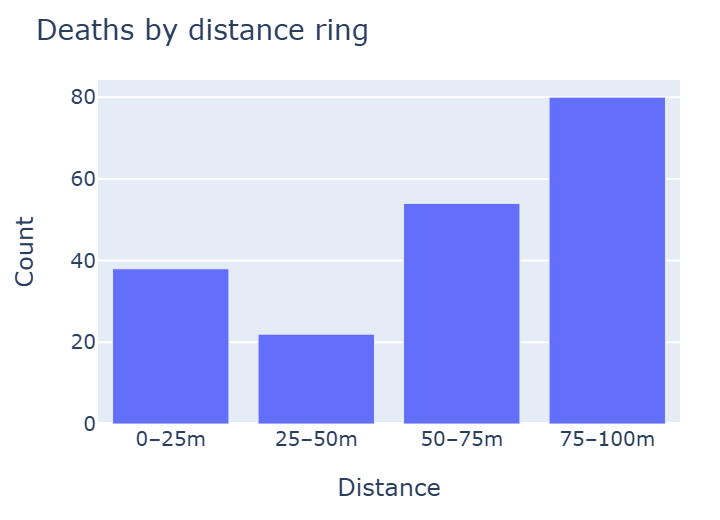
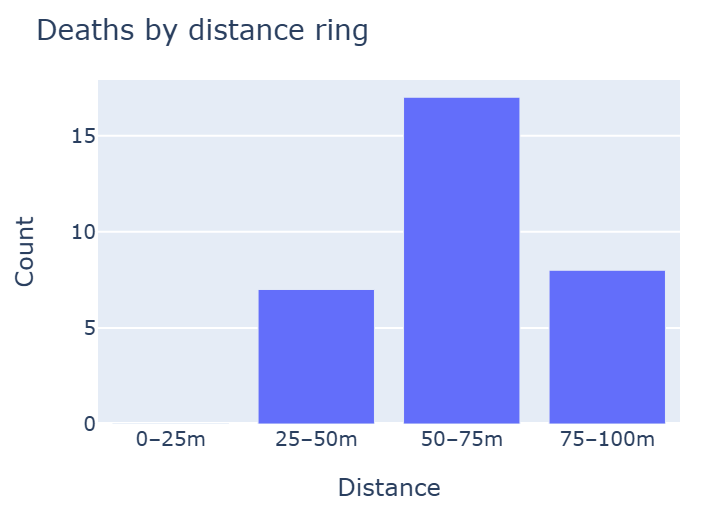
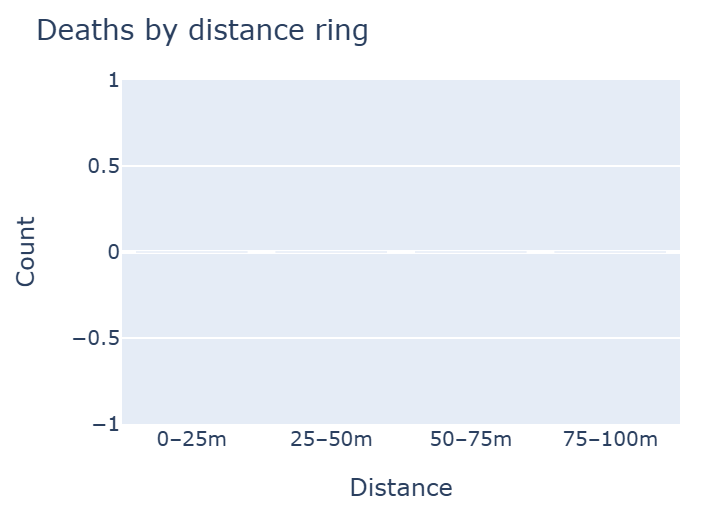
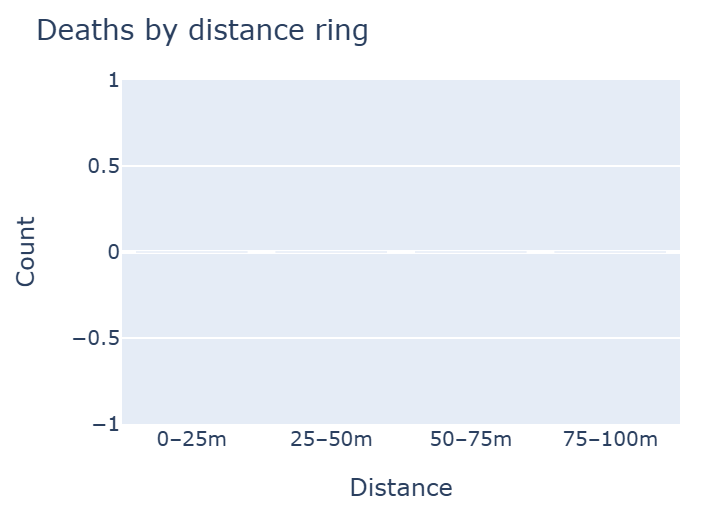
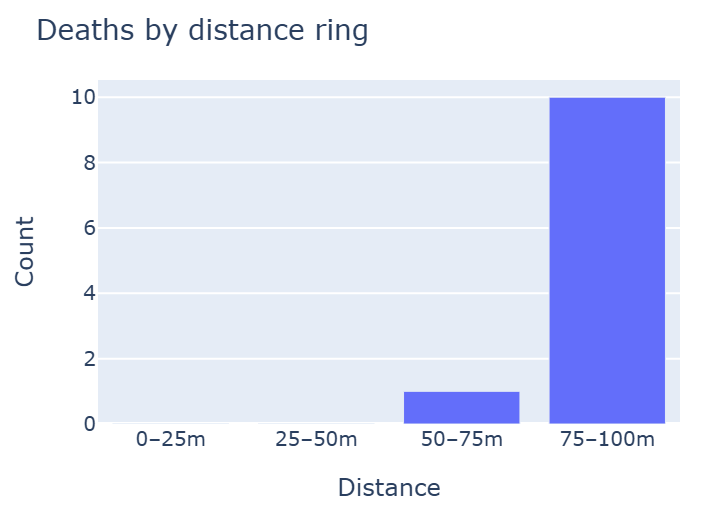
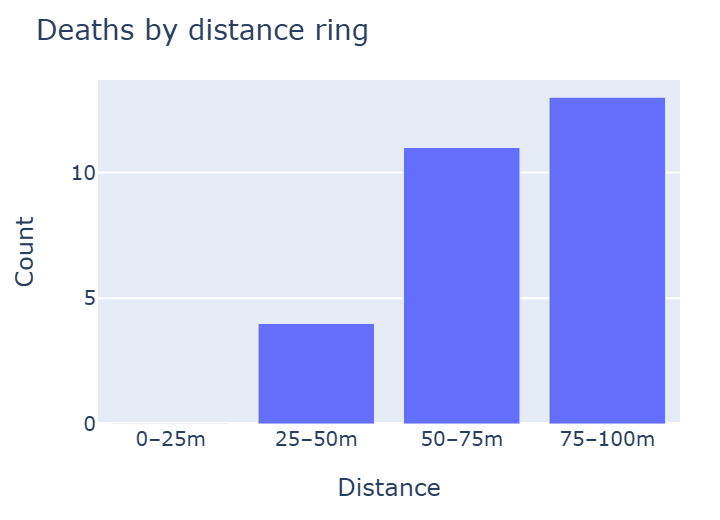
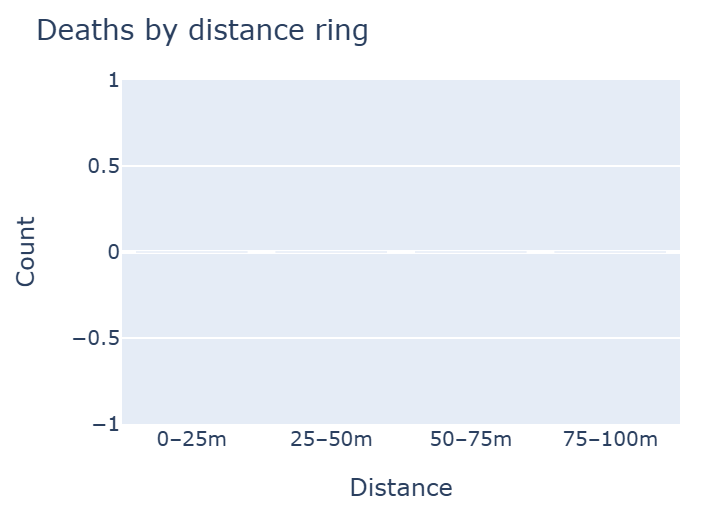
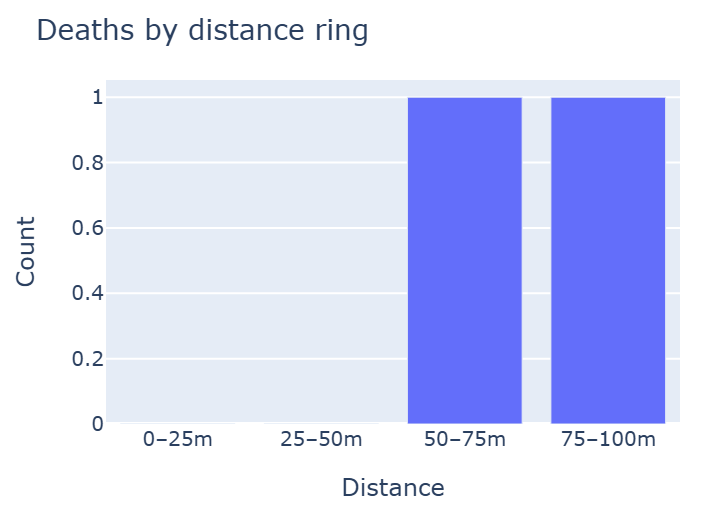

In [10]:
pl.add_to(m)
folium.LayerControl(collapsed=True).add_to(m)

from IPython.display import display
display(m)

# Timeline of Deaths

This section visualizes the temporal progression of cholera deaths in Soho during 1854. A line chart is created to show how daily deaths peaked around early September and sharply declined after the removal of the Broad Street pump handle, marking a key turning point in the epidemic.

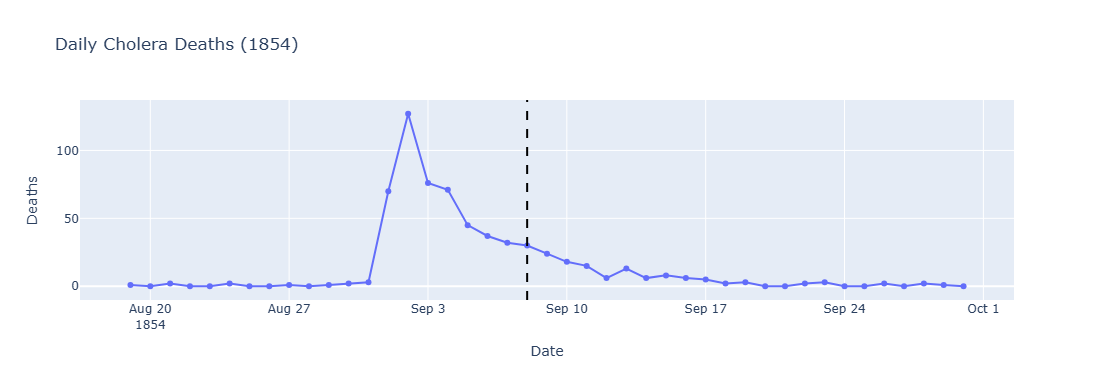

In [11]:
import pandas as pd
import plotly.express as px

# Read CSV and map columns 
df = pd.read_csv("datas/snow_dates.csv")

cols = {c.lower(): c for c in df.columns}
date_col  = next((cols[k] for k in ["date","day","dt","tarih"] if k in cols), None)
count_col = next((cols[k] for k in ["deaths","death","death_count","count","cases"] if k in cols), None)
assert date_col and count_col, f"Not found. Columns: {list(df.columns)}"

# Keep only necessary columns with clear names
df = df[[date_col, count_col]].rename(columns={date_col:"date", count_col:"deaths"})

# Parse the date
df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=False)
df = df.dropna(subset=["date"])

# Get daily totals and sort
daily = (df.groupby("date", as_index=False)["deaths"].sum()
           .sort_values("date"))

# Plot
fig = px.line(daily, x="date", y="deaths", markers=True,
              title="Daily Cholera Deaths (1854)",
              labels={"date":"Date", "deaths":"Deaths"})

# The day the pump handle was removed
fig.add_vline(x="1854-09-08", line_dash="dash", line_color="black")

fig.update_layout(height=380, width=900)
fig.show()


# Conclusion

Transforming John Snow’s cholera map into an interactive digital visualization fundamentally changes its structure and purpose. While the original 1854 map served primarily as rhetorical evidence, a static argument proving the link between contaminated water and cholera—the modern, data-driven version becomes an exploratory tool. By adding heatmaps, zooming, and interactive popups, viewers can now manipulate and interrogate the data rather than passively observe it.

Additionally, integrating a timeline line chart extends this interactivity into the temporal dimension, allowing users to trace the outbreak’s progression day by day. This not only reveals how deaths peaked and declined around the removal of the Broad Street pump handle but also connects spatial and temporal patterns in a unified analytical view.

Together, these enhancements make the visualization more persuasive through engagement; encouraging exploration, comparison, and critical interpretation. Modern techniques like dynamic layers, embedded charts, and temporal trends transform Snow’s historical map into a living analytical interface, bridging 19th-century epidemiology with contemporary data storytelling.

# References

[1]	https://3d-mapper.com/_MAP/index.php

[2]	https://blog.rtwilson.com/john-snows-cholera-data-in-more-formats/

[3]	https://github.com/epibayes/john-snow-data

[4]	https://learn.arcgis.com/en/projects/map-a-historic-cholera-outbreak/

[5]	https://www.google.com/maps/d/u/0/edit?hl=tr&mid=1_WdhO0E4vnweywSxgJmz0RtuRKStOUI&ll=51.51256020834711%2C-0.13718657708763793&z=18